In [107]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'x1': load_data('../stats/fpm_4_2D_x1.json'),
    'x4': load_data('../stats/fpm_4_2D_x2.json'),
    'x9': load_data('../stats/fpm_4_2D_x3.json'),
    'x16': load_data('../stats/fpm_4_2D_x4.json'),
    # 'x25': load_data('../stats/fpm_4_2D_x5.json')
    # 'x64': load_data('../stats/fpm_4_2D_x8.json'),
}

In [108]:
shape = [4, 1]
figsize = (7, 6)

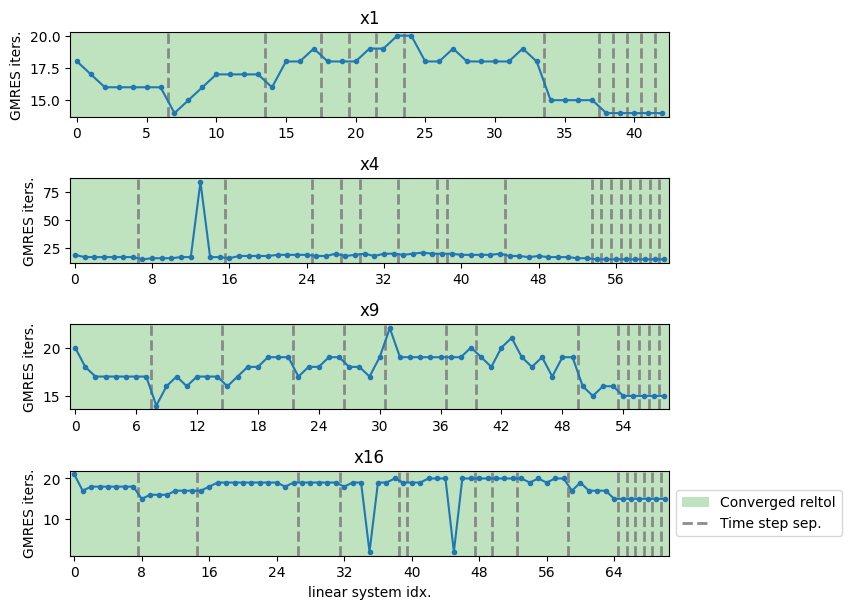

In [109]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

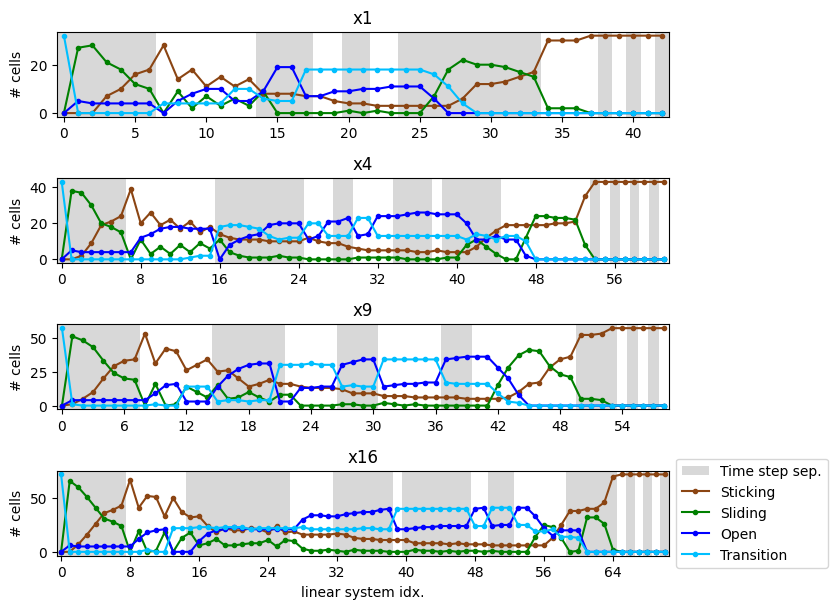

In [110]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

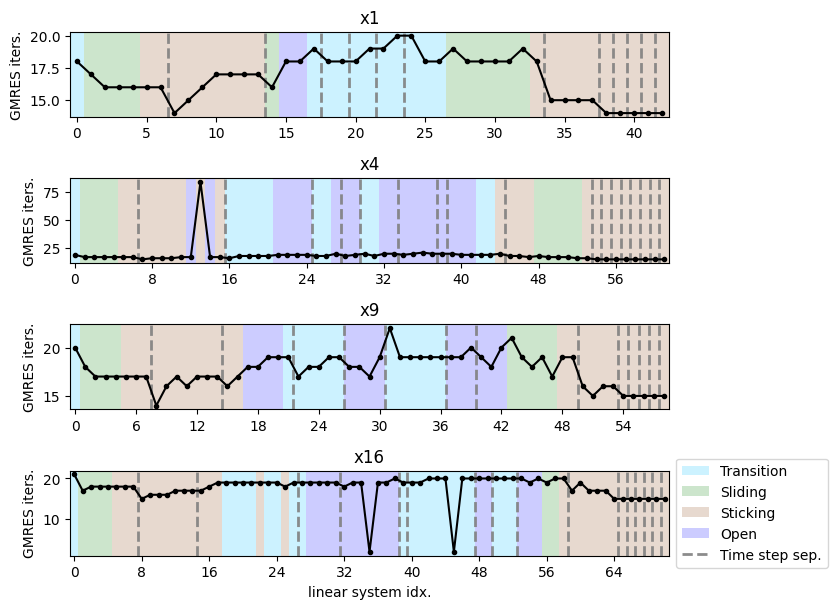

In [111]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')
    # plt.ylim(top=15)

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

In [112]:
# i = 1
# def render_element(entry: Sequence[TimeStepStats]):
#     global i
#     from fpm_5_2D import make_model
    
#     model = make_model(cell_size_multiplier=i)
#     i += 1
#     model.prepare_simulation()
#     model._initialize_solver()
#     model.assemble_linear_system()
#     nrms = get_rhs_norms(model, entry, ord=np.inf)
#     for j, nrm in enumerate(nrms):
#         plt.plot(nrm, label=j)
#     color_converged_reason(entry)
#     color_time_steps(entry)
#     plt.yscale('log')

# plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

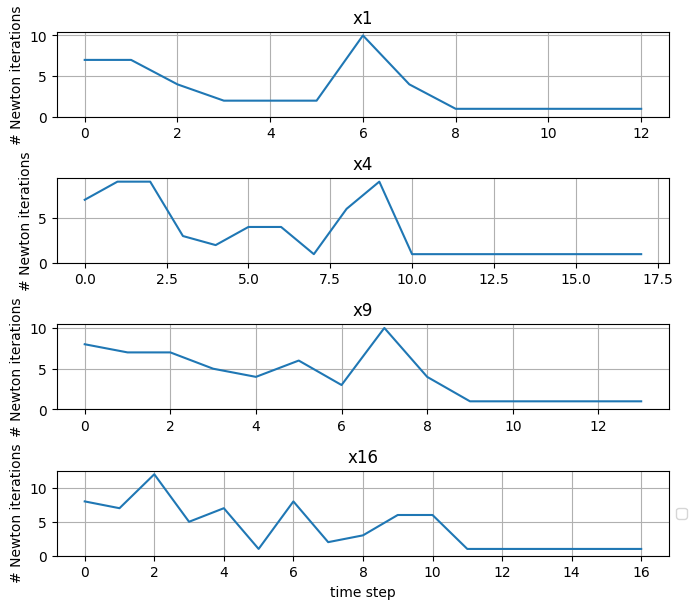

In [113]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [114]:
assert False

AssertionError: 

In [ ]:
from fpm_5_2D import make_model

model = make_model(cell_size_multiplier=3)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 57


In [ ]:
mat_idx = 50
entry = data['x9']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

16


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1
model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

# model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

52
5
0
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


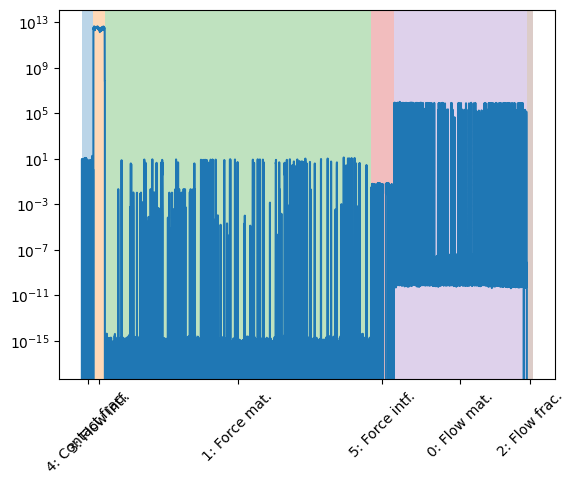

In [ ]:
ones = np.ones(perm_mat.shape[0])
tmp = perm_mat
tmp.color_local_rhs(tmp.local_rhs(perm_mat.global_rhs(perm_mat.mat @ ones)))
plt.yscale('log')

In [ ]:
np.linalg.norm(tmp.local_rhs(perm_mat.global_rhs(perm_mat.mat @ ones)))

32139051006640.812

In [ ]:
# ones = np.ones(perm_mat.shape[0])
# tmp.color_local_rhs(tmp.local_rhs(mat @ sol - rhs))
# plt.yscale('log')

Solve  took: 0.1
True residual decrease: 0.010995024784569953


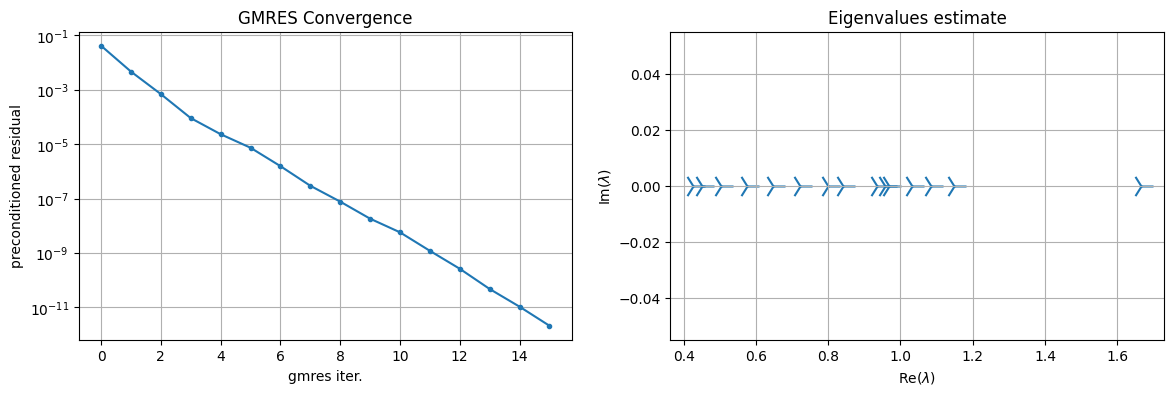

In [ ]:
sol = None
sol = solve_petsc(perm_mat.mat, prec_orig, rhs=model.rhs_Q, pc_side='left', tol=1e-10, return_solution=True)

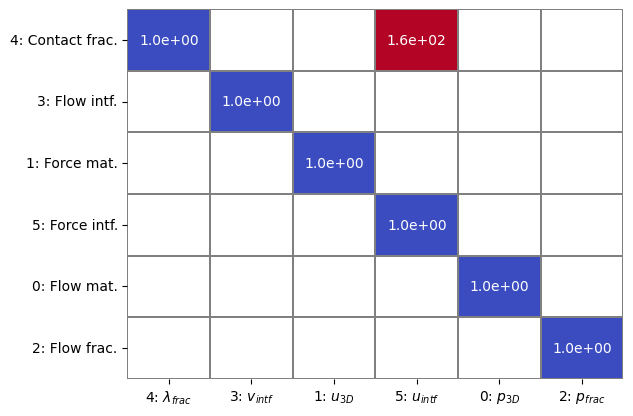

In [ ]:
model.Q_perm.plot_max()

Solve  took: 0.1
True residual decrease: 0.010995024784569953


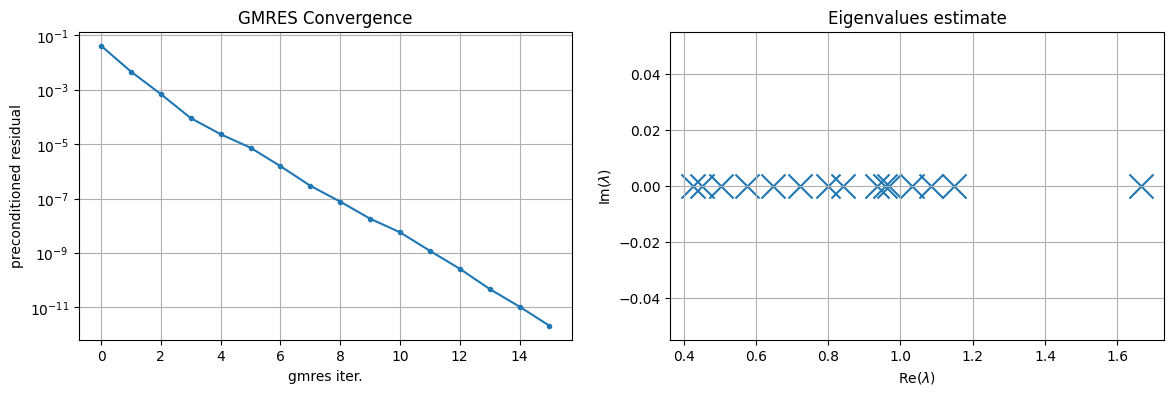

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs, get_fixed_stress_stabilization, make_local_stab_15

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # only_complement=True,
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: model._fixed_stress.mat,
            # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            # invertor=lambda bmat: make_local_stab_15(bmat=perm_mat, base=2, nd=1),
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

rhs_Q_global = model.Q_perm.global_rhs(model.rhs_Q)
bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=perm_mat)
# preconditioner.pc.view()

solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs_Q_global), pc_side='left', tol=1e-10, ksp_view=False)

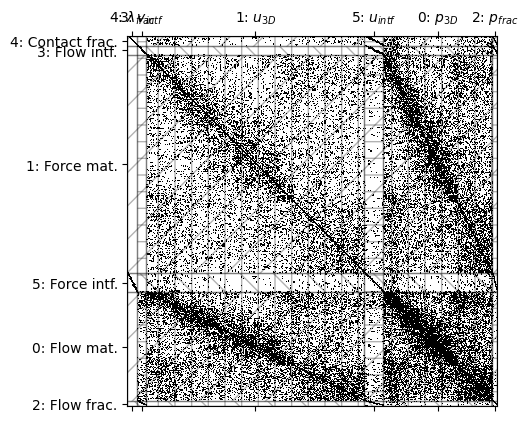

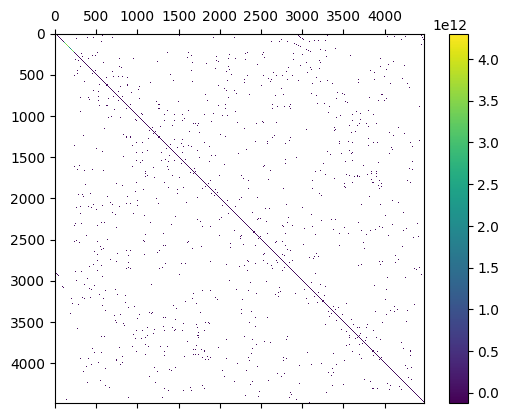

In [ ]:
# %matplotlib inline
bmat_reordered.color_spy(hatch=True, color=False)
bmat_reordered.matshow(log=False)

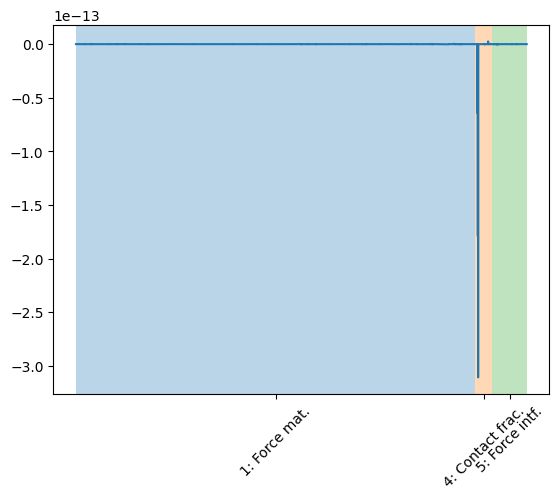

In [ ]:
tmp = bmat_reordered[[1, 4, 5]]
tmp.color_local_rhs(tmp.local_rhs(rhs_Q_global))

# Observation:
* GMRES converges - $\text{rhs}_4 \approx 10^{-5}$ 
* GMRES diverges - $\text{rhs}_4 \approx 10^{-11}$ 

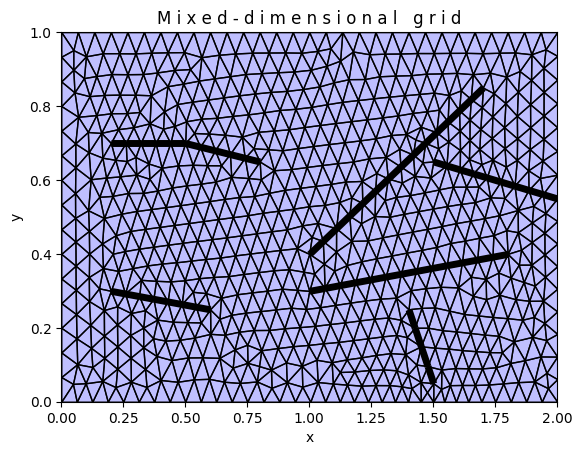

In [ ]:
pp.plot_grid(
    model.mdg,
    alpha=0.5,
    rgb=[0.5, 0.5, 1],
    plot_2d=True,
    fracturewidth_1d=5,
)